I show that the original Taylens code only works when the monopole and dipole are absent from the input spectra. 

This longer notebook has to take apart the `cl_tebp_arr` created in the `run_taylens()` method.

In [1]:
import numpy as np
from itertools import product
from pysm3.models import Model, CMBLensed

CAMB output power spectra include the monopole and dipole ($\ell=0$ and $\ell=1$), but the `c1` power spectra do not:

In [ ]:
ps_camb = "demo_powerspectra/camb_ps.dat"  # Only used to demonstrate that CAMB output includes L=0,1
ps_c1 = "demo_powerspectra/c1_ps.dat"

print("CAMB output power spectra:")
with open(ps_camb, "r") as f:
    for i in range(6):
        print(' '*5, f.readline().rstrip())

print("Original c1 power spectra:")
with open(ps_c1, "r") as f:
    for i in range(4):
        print(' '*5, f.readline().rstrip())

I've manually added two lines to a modified version of the `c1` power spectra file (for use with this example):

In [ ]:
ps_c1_with_l01 = "demo_powerspectra/c1_ps_l01.dat"

print("Modified c1 power spectra, to be used for demonstration in the notebook:")
with open(ps_c1_with_l01, "r") as f:
    for i in range(6):
        print(' '*5, f.readline().rstrip())

# Presence of the monopole and dipole affect the rearranged `cl_tebp_arr`

The method duplicates [lines 290-338 from pysm/src/pysm3/models/cmb.py](./src/pysm3/models/cmb.py#L290C1-L338C20).

In [3]:
def orig_method(self):
    synlmax = 8 * self.nside  # this used to be user-defined.
    data = self.cmb_spectra
    lmax_cl = len(data[0]) + 1

    ell = np.arange(int(lmax_cl + 1))
    synlmax = min(synlmax, ell[-1])

    # Reading input spectra in CAMB format. CAMB outputs l(l+1)/2pi hence the corrections.
    cl_tebp_arr = np.zeros([10, lmax_cl + 1])
    cl_tebp_arr[0, 2:] = 2 * np.pi * data[1] / (ell[2:] * (ell[2:] + 1))  # TT
    cl_tebp_arr[1, 2:] = 2 * np.pi * data[2] / (ell[2:] * (ell[2:] + 1))  # EE
    cl_tebp_arr[2, 2:] = 2 * np.pi * data[3] / (ell[2:] * (ell[2:] + 1))  # BB
    cl_tebp_arr[4, 2:] = 2 * np.pi * data[4] / (ell[2:] * (ell[2:] + 1))  # TE
    cl_tebp_arr[5, :] = np.zeros(lmax_cl + 1)  # EB
    cl_tebp_arr[7, :] = np.zeros(lmax_cl + 1)  # TB

    if self.apply_delens:  # This case can be ignored for issue 212
        cl_tebp_arr[3, 2:] = (
            2
            * np.pi
            * data[5]
            * self.delensing_ells[1]
            / (ell[2:] * (ell[2:] + 1)) ** 2
        )  # PP
        cl_tebp_arr[6, :] = np.zeros(lmax_cl + 1)  # BP
        cl_tebp_arr[8, 2:] = (
            2
            * np.pi
            * data[7]
            * np.sqrt(self.delensing_ells[1])
            / (ell[2:] * (ell[2:] + 1)) ** 1.5
        )  # EP
        cl_tebp_arr[9, 2:] = (
            2
            * np.pi
            * data[6]
            * np.sqrt(self.delensing_ells[1])
            / (ell[2:] * (ell[2:] + 1)) ** 1.5
        )  # TP
    else:
        cl_tebp_arr[3, 2:] = (
            2 * np.pi * data[5] / (ell[2:] * (ell[2:] + 1)) ** 2
        )  # PP
        cl_tebp_arr[6, :] = np.zeros(lmax_cl + 1)  # BP
        cl_tebp_arr[8, 2:] = (
            2 * np.pi * data[7] / (ell[2:] * (ell[2:] + 1)) ** 1.5
        )  # EP
        cl_tebp_arr[9, 2:] = (
            2 * np.pi * data[6] / (ell[2:] * (ell[2:] + 1)) ** 1.5
        )  # TP

    ############################### End of copied portion.
    return cl_tebp_arr

I need a placeholder object to act as "`self`."

In [4]:
class SurrogateCMBLensed(Model):
    def __init__(self, ps_file, apply_delens=False, nside=2048):
        super().__init__(nside=nside)
        self.nside = nside
        self.cmb_seed = 8675309
        self.cmb_spectra = self.read_txt(ps_file, unpack=True)
        self.apply_delens = apply_delens
        # self.delensing_ells = self.read_txt(delensing_ells_fp)  # Change needed!
        self._map = None

I compare how `cl_tebp_arr` is built from `ps_c1` and `ps_c1_l01`:

In [8]:
tebp_orig_wout_l01 = orig_method(SurrogateCMBLensed(ps_c1))
tebp_orig_with_l01 = orig_method(SurrogateCMBLensed(ps_c1_with_l01))

In [9]:
tebp_orig_wout_l01.shape, tebp_orig_with_l01.shape  # Shapes are expected to be different (two rows have been added to the latter)

((10, 2201), (10, 2203))

I print the numbers - it shows what's going on, but not as clearly. You can also see that because the normalization factors involve $\ell$, the $C_\ell$ values change; they aren't just shifted.

In [10]:
np.set_printoptions(precision=2, suppress=True, formatter={'float': '{:.2e}'.format}, linewidth=100)

def compare_tebp_num(tebps, labels, show_lmax=5):
    for i in range(show_lmax):
        print()
        for label, tebp in zip(labels, tebps):
            print(f"{label}: {tebp[:, i]}")

We see the misalignment, just printing the values:

In [11]:
compare_tebp_num([tebp_orig_wout_l01, tebp_orig_with_l01], ["wout l01", "with l01"])


wout l01: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
with l01: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]

wout l01: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
with l01: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]

wout l01: [1.12e+03 3.59e-02 0.00e+00 8.60e-09 2.84e+00 0.00e+00 0.00e+00 0.00e+00 -5.49e-06 1.38e-03]
with l01: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]

wout l01: [5.25e+02 2.42e-02 0.00e+00 2.62e-09 1.64e+00 0.00e+00 0.00e+00 0.00e+00 -2.14e-06 4.86e-04]
with l01: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]

wout l01: [2.96e+02 1.33e-02 0.00e+00 1.09e-09 9.46e-01 0.00e+00 0.00e+00 0.00e+00 -8.75e-07 2.20e-04]
with l01: [3.35e+02 1.08e-02 0.00e+00 7.74e-10 8.51e-01 0.00e+00 0.00e+00 

Those are power spectra ($C_\ell$). It's hard to see that they're the same values, just shifted. 

I convert back to band power ($D_\ell$) to show the difference. (I'm not a physics person - please let me know if my terminology is wrong!)

In [12]:
def build_tebp_dl2cl_scale(tebp_shape):
    use_lmax = tebp_shape[1] - 1
    ell = np.arange(use_lmax + 1)
    ell[0] = 1

    scale = np.zeros([10, use_lmax + 1])
    scale[0] = 2 * np.pi / (ell * (ell + 1))         # TT
    scale[1] = 2 * np.pi / (ell * (ell + 1))         # EE
    scale[2] = 2 * np.pi / (ell * (ell + 1))         # BB
    scale[3] = 2 * np.pi / (ell * (ell + 1)) ** 2    # PP
    scale[4] = 2 * np.pi / (ell * (ell + 1))         # TE
    scale[5] = 2 * np.pi / (ell * (ell + 1))         # EB
    scale[6] = 2 * np.pi / (ell * (ell + 1))         # BP
    scale[7] = 2 * np.pi / (ell * (ell + 1))         # TB
    scale[8] = 2 * np.pi / (ell * (ell + 1)) ** 1.5  # EP
    scale[9] = 2 * np.pi / (ell * (ell + 1)) ** 1.5  # TP

    return scale

def cl2dl_tebp(tebp):
    scale = build_tebp_dl2cl_scale(tebp.shape)
    return tebp / scale

In [13]:
tebp_orig_with_l01_dl = cl2dl_tebp(tebp_orig_with_l01)
tebp_orig_wout_l01_dl = cl2dl_tebp(tebp_orig_wout_l01)

In [14]:
import matplotlib.pyplot as plt

def compare_tebp(tebps, labels, show_lmax=10):
    tebp_idcs = ["TT", "EE", "BB", "PP", "TE", "EB", "BP", "TB", "EP", "TP"]

    for i in range(10):
        if i in [2, 5, 6, 7]:
            continue
        plt.figure()
        for j, tebp in enumerate(tebps):
            plt.plot(tebp[i][:show_lmax], label=labels[j], 
                    #  linewidth=(3-j), 
                     marker=str(j+1), markersize=10)
        plt.title(f"idx {i}, {tebp_idcs[i]}")
        plt.legend()
        plt.show()

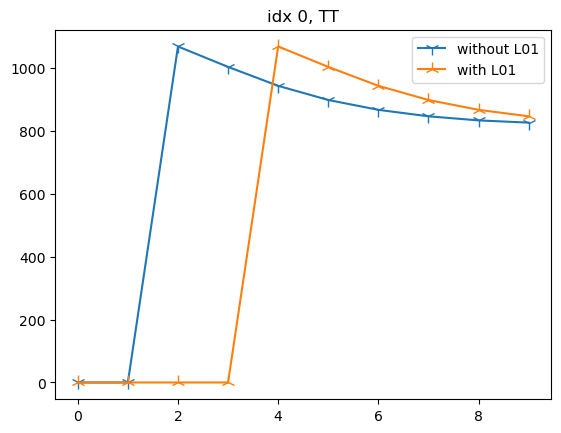

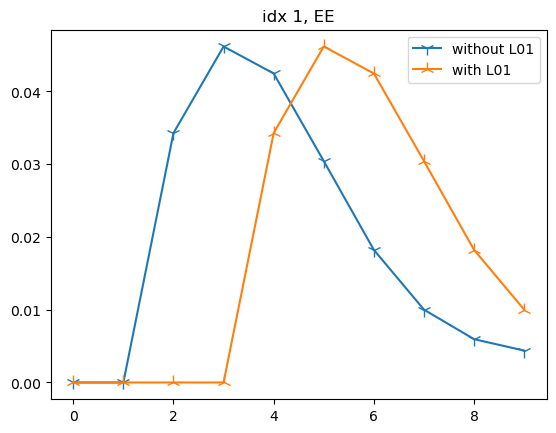

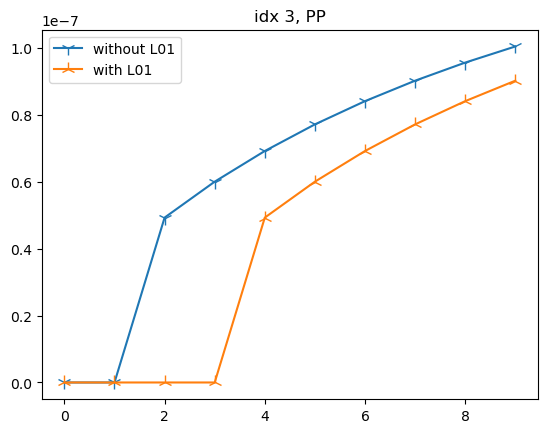

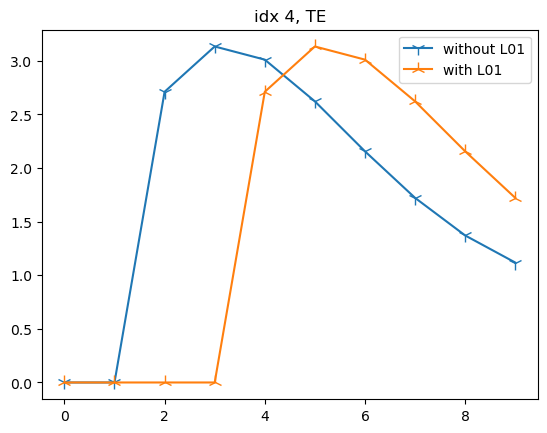

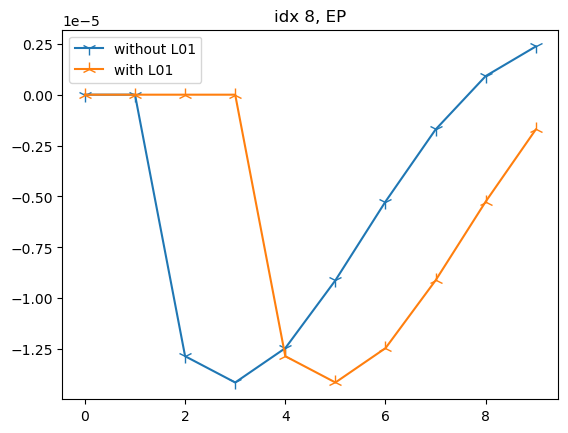

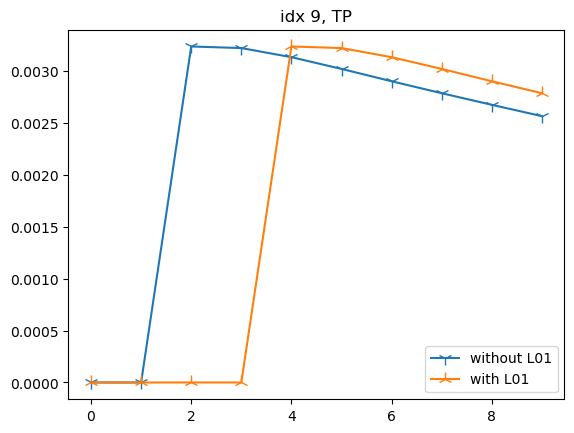

In [15]:
compare_tebp([tebp_orig_wout_l01_dl, tebp_orig_with_l01_dl], ["without L01", "with L01"], 10)

This has illustrated that the `cl_tebp_arr` depends on L=0 and L=1 be absent. When present, `cl_tebp_arr` is incorrect.

# Show resulting maps

In [16]:
import healpy as hp

In [17]:
def compare_maps(params, dl1 = ps_c1, dl2 = ps_c1_with_l01, label1="Original c1", label2="c1 with L=0,1"):
    m1 = CMBLensed(cmb_spectra = dl1, **params).map
    m2 = CMBLensed(cmb_spectra = dl2, **params).map
    fig, axs = plt.subplots(3, 3, figsize=(12, 8))
    plt.sca(axs[0,0])
    hp.mollview(m2[0], title=f"{label1} T", hold=True)
    plt.sca(axs[0,1])
    hp.mollview(m2[1], title=f"{label1} Q", hold=True)
    plt.sca(axs[0,2])
    hp.mollview(m2[2], title=f"{label1} U", hold=True)
    plt.sca(axs[1,0])
    hp.mollview(m1[0], title=f"{label2} T", hold=True)
    plt.sca(axs[1,1])
    hp.mollview(m1[1], title=f"{label2} Q", hold=True)
    plt.sca(axs[1,2])
    hp.mollview(m1[2], title=f"{label2} U", hold=True)
    plt.sca(axs[2,0])
    hp.mollview(m1[0] - m2[0], title="Delta T", hold=True)
    plt.sca(axs[2,1])
    hp.mollview(m1[1] - m2[1], title="Delta Q", hold=True)
    plt.sca(axs[2,2])
    hp.mollview(m1[2] - m2[2], title="Delta U", hold=True)
    plt.show()

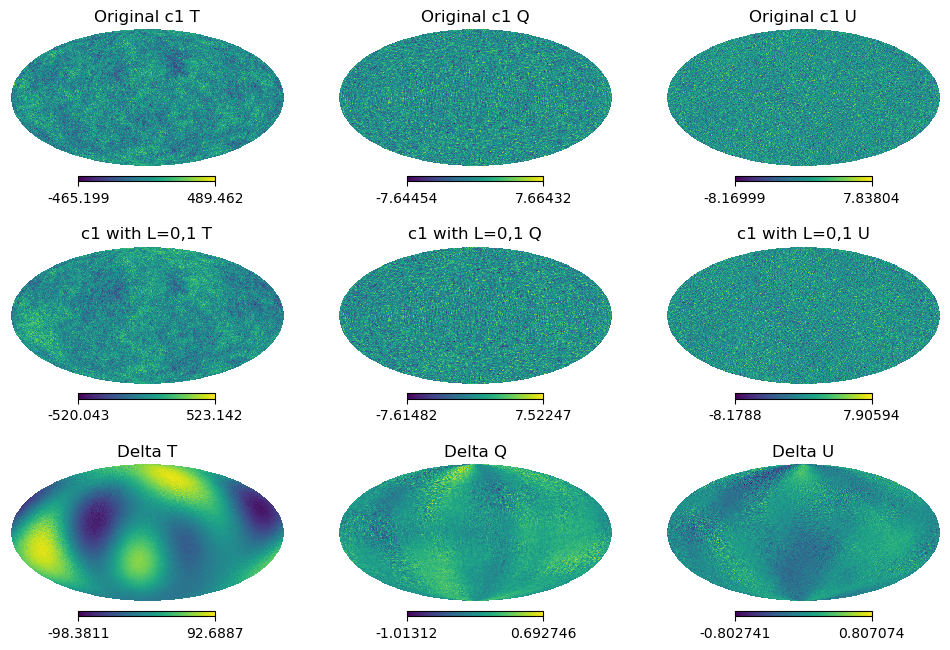

In [ ]:
params = dict(
    nside=128,
    max_nside=None,
    cmb_seed=0,
    apply_delens=False,
    delensing_ells=None,
    map_dist=None,
)
compare_maps(params, dl1=ps_c1, dl2=ps_c1_with_l01)

The previous section showed the difference in `cl_tebp_arr`. This shows that the change in `cl_tebp_arr` has an impact on the output maps.